Importing Libraries

In [5]:
pip install xgboost --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from time import time
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from tqdm.auto import tqdm


In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Importing Data

In [3]:
df=pd.read_csv('./movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,40000.0,0.499525,0.500006,0.0,0.0,0.0,1.0,1.0


Data Exploration

In [6]:
#Looking for null data
df.isna().sum()

text     0
label    0
dtype: int64

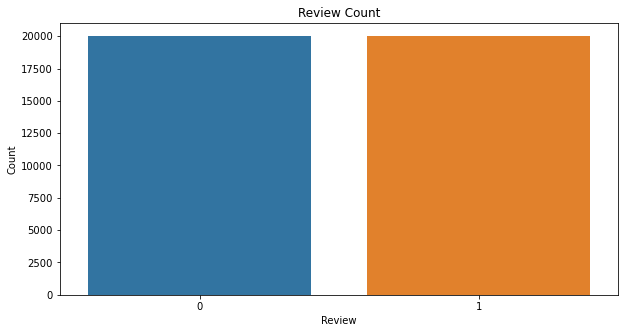

In [7]:
#Generating a countplot for target label
plt.figure(figsize=(10,5))
sns.barplot(x=df['label'].value_counts().index,y=df['label'].value_counts())
plt.title('Review Count')
plt.xlabel('Review')
plt.ylabel('Count');

Feature Engineering

* num_of_words: Number of words in the review
* num_of_chars: Number of characters in the review

In [8]:
#Generating the column text_len
df['num_of_words']=df['text'].apply(lambda x:len(x.split(' ')))
df.head()

,text,label,num_of_words
0,I grew up (b. 1965) watching and loving the Th...,0,151
1,"When I put this movie in my DVD player, and sa...",0,326
2,Why do people who do not know what a particula...,0,184
3,Even though I have great interest in Biblical ...,0,69
4,Im a die hard Dads Army fan and nothing will e...,1,178


In [9]:
#Generating the column char_len
def char_count(text):
    charc=0
    for char in text.split():
        charc +=len(char)
    return charc

df['num_of_chars']=df['text'].apply(char_count)

In [10]:
df.groupby('label').describe().T

label                          0             1
num_of_words count  20019.000000  19981.000000
             mean     229.195165    233.466844
             std      164.316689    177.766087
             min        4.000000     12.000000
             25%      128.000000    125.000000
             50%      174.000000    173.000000
             75%      278.500000    285.000000
             max     1522.000000   2470.000000
num_of_chars count  20019.000000  19981.000000
             mean    1064.313602   1095.581552
             std      778.468501    855.119309
             min       27.000000     52.000000
             25%      579.000000    567.000000
             50%      800.000000    800.000000
             75%     1295.000000   1338.000000
             max     7448.000000  11235.000000

Text Preprocessing

preprocess the data to convert it into a form that can be understandable for computer.

* Convert to Lowercase
* Remove punctuations
* Remove stopwords
* Lemmatization

In [47]:
#droping stopwords and lemmatizing
nltk.download('stopwords')
sws=stopwords.words('english')
sws.remove('not')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(doc):
    lem = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return ' '.join([lem.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/berksicak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/berksicak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/berksicak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [48]:
#removing punctuations and converting lowercase
def clean_text(text):
    text=str(text).lower()
    text=re.sub('\[.*?\]', '', text)
    text=re.sub('https?://\S+|www\.\S+', '', text)
    text=re.sub('<.*?>+', '', text)
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = lemmatizer(text)
    return text

In [49]:
def drop_stopwords(text):
    text= ' '.join(word for word in text.split(' ') if word not in sws)#dropping stopwords
    return text

In [50]:
df['clean']=df['text'].apply(clean_text)

In [51]:
nltk.download('omw-1.4')
nltk.download('wordnet')

df['final']=df['clean'].apply(drop_stopwords)
df.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/berksicak/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/berksicak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,label,num_of_words,num_of_chars,clean,final,final2
0,I grew up (b. 1965) watching and loving the Th...,0,151,724,i grow up b watching and love the thunderbird ...,grow b watching love thunderbird mate school w...,grow watching love thunderbird mate school wat...
1,"When I put this movie in my DVD player, and sa...",0,326,1486,when i put this movie in my dvd player and sit...,put movie dvd player sit coke chip expectation...,put movie dvd player sit coke chip expectation...
2,Why do people who do not know what a particula...,0,184,800,why do people who do not know what a particula...,people not know particular time past like feel...,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,69,283,even though i have great interest in biblical ...,even though great interest biblical movie bore...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,178,806,im a die hard dad army fan and nothing will ev...,im die hard dad army fan nothing ever change g...,die hard dad army fan nothing ever change get ...


In [52]:
#removing words which has 2 or less chars
df['final2']=df['final'].apply(lambda x:' '.join(text for text in x.split(' ') if len(text)>2))
df.head()

,text,label,num_of_words,num_of_chars,clean,final,final2
0,I grew up (b. 1965) watching and loving the Th...,0,151,724,i grow up b watching and love the thunderbird ...,grow b watching love thunderbird mate school w...,grow watching love thunderbird mate school wat...
1,"When I put this movie in my DVD player, and sa...",0,326,1486,when i put this movie in my dvd player and sit...,put movie dvd player sit coke chip expectation...,put movie dvd player sit coke chip expectation...
2,Why do people who do not know what a particula...,0,184,800,why do people who do not know what a particula...,people not know particular time past like feel...,people not know particular time past like feel...
3,Even though I have great interest in Biblical ...,0,69,283,even though i have great interest in biblical ...,even though great interest biblical movie bore...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,178,806,im a die hard dad army fan and nothing will ev...,im die hard dad army fan nothing ever change g...,die hard dad army fan nothing ever change get ...


In [ ]:
#this chart shows frequency of words in positive rewievs after all preprocessing stage
freqw=df[df['label']==1]['final2'].str.split(expand=True).stack().value_counts()
freqw200=freqw[:200]

fig=px.treemap(freqw200,path=[freqw200.index],values=0)
fig.update_traces(textinfo="label+value")
fig.show()

In [ ]:
#this chart shows frequency of words in negative rewievs after all preprocessing stage
freqw=df[df['label']==0]['final2'].str.split(expand=True).stack().value_counts()
freqw200=freqw[:200]

fig=px.treemap(freqw200,path=[freqw200.index],values=0)
fig.update_traces(textinfo="label+value")
fig.show()

Wordclouds

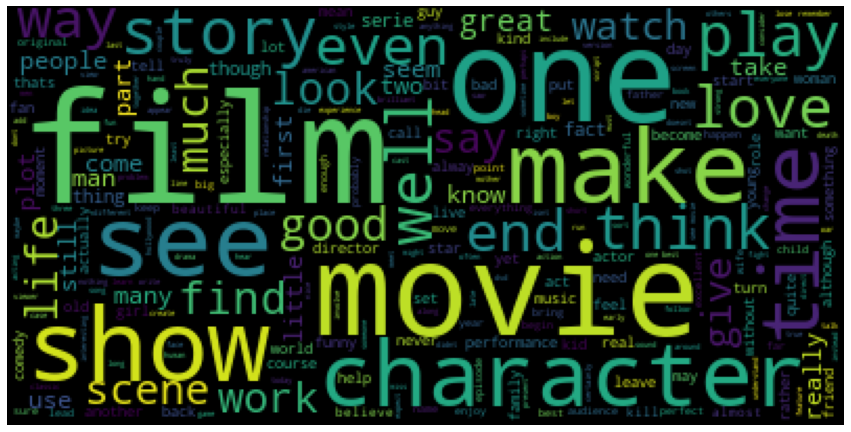

In [55]:
plt.figure(figsize=(15,10))
wc=WordCloud(max_words=500,background_color='black')
wc.generate(' '.join(word for word in df.loc[df['label']==1,'final2']))
plt.imshow(wc)
plt.axis('off')
plt.show()

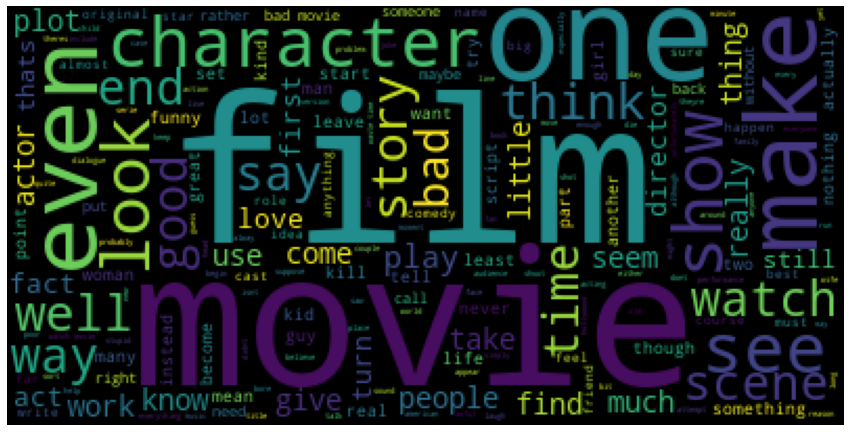

In [56]:
plt.figure(figsize=(15,10))
wc=WordCloud(max_words=500,background_color='black')
wc.generate(' '.join(word for word in df.loc[df['label']==0,'final2']))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [57]:
X=df['final2']
y=df['label']

In [58]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [59]:
def pipelining(model):
    pipe=Pipeline([('tfidf',TfidfVectorizer()),('model',model)])
    t0 = time()
    pipe.fit(X_train,y_train)
    total_time = time() - t0
    print(f"Total time during the model training:{total_time}")
    y_pred=pipe.predict(X_test)
    acc = round(metrics.accuracy_score(y_test,y_pred),3)*100
    pre = round(metrics.precision_score(y_test,y_pred),3)*100
    rec = round(metrics.recall_score(y_test,y_pred),3)*100
    f1 = round(metrics.f1_score(y_test,y_pred),3)*100
    roc = round(metrics.roc_auc_score(y_test,y_pred),3)*100
    print('Accuracy Score: ',acc)
    print(metrics.classification_report(y_test,y_pred))
    metrics.plot_confusion_matrix(pipe,X_test,y_test)
    return pipe, acc, pre, rec, f1, roc

In [60]:
def find_best_model(models ,model_names):
    max_acc = 0
    for i in range (0, len(models)):
        pipe, acc , pre, rec, f1, roc= pipelining(models[i])
        if max_acc<acc:
            best_pipe = pipe
            max_acc=acc
        Evaluation_Results.loc[model_names[i]]['Accuracy']=acc
        Evaluation_Results.loc[model_names[i]]['Precision']=pre
        Evaluation_Results.loc[model_names[i]]['Recall']=rec
        Evaluation_Results.loc[model_names[i]]['F1-score']=f1
        Evaluation_Results.loc[model_names[i]]['AUC-ROC score']=roc
    return best_pipe, Evaluation_Results

In [ ]:
models=[]
model_names =["MultinomialNB", "BernoulliNB", "LogisticRegression", "XGBClassifier", "RandomForestClassifier"]
models.append(MultinomialNB())
models.append(BernoulliNB())
models.append(LogisticRegression(fit_intercept=True, class_weight=None, max_iter=1000, random_state=42))
models.append(XGBClassifier())
models.append(RandomForestClassifier())
Evaluation_Results = pd.DataFrame(np.zeros((5,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=["MultinomialNB", "BernoulliNB", "LogisticRegression", "XGBClassifier", "RandomForestClassifier"]
pipe, Evaluation_Results = find_best_model(models, model_names)

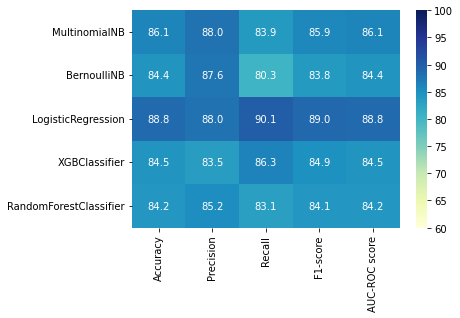

In [38]:
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()

In [41]:
def try_new_review(pipe, sentence):
    text = clean_text(sentence)
    text = drop_stopwords(text)
    if pipe.predict([text]) == 1:
        print("The given sentence is positive :)")
    else :
        print("The given sentence is negative :(")


In [72]:
try_new_review(pipe, "best film ever")
try_new_review(pipe, "worst film ever")
negative_reviews = [    "I was really excited to see 'The Never-Ending Story,' but when I got to the theater, it was nowhere to be found. Disappointing.",
           "I can't believe they made a movie called 'The Phantom Menace' and then just didn't release it. What a waste of my time.",    
           "I was looking forward to watching 'The Time Traveler's Wife,' but it seems like it was just a figment of my imagination. So disappointing.",
           "I can't believe they made a movie called 'The Chronicles of Narnia: The Silver Chair' and then never actually released it. Such a letdown.",
           "I was really excited to see 'The Light Between Oceans,' but it turns out it was just a mirage. Such a disappointment."]
positive_reviews = [    "I saw 'The Great Heist' over the weekend and was blown away by the nonstop action and twists. The cast was top-notch and the heist itself was expertly executed. Definitely worth a watch!", 
           "I can't stop thinking about 'Love on the Rocks' - the chemistry between the lead actors was electric and the romantic storyline had me on the edge of my seat. A must-see for any romantic comedy fan.",   
           "As a huge fan of sci-fi, I was excited to see 'Galactic Odyssey' and it did not disappoint. The special effects were out of this world (pun intended) and the story kept me guessing until the very end. Highly recommend.",  
           "I wasn't sure what to expect from 'The Haunted House' but it ended up being one of the scariest movies I've seen in a long time. The atmosphere was tense and the jump scares were expertly done. Definitely not for the faint of heart.",   
           "I was pleasantly surprised by 'The Art of Deception'. The plot was complex and kept me guessing until the very end. The acting was superb and the twists were well executed. Highly recommend for fans of mystery and suspense.",    "I laughed, I cried, I gasped - 'The Family Reunion' had it all. The cast was talented and the story was heartwarming. A must-see for any fan of family dramas."]
for i in range (0,5):
    try_new_review(pipe, negative_reviews[i])
for i in range (0,5):
    try_new_review(pipe, positive_reviews[i])


The given sentence is positive :)
The given sentence is negative :(
The given sentence is negative :(
The given sentence is negative :(
The given sentence is negative :(
The given sentence is negative :(
The given sentence is negative :(
The given sentence is positive :)
The given sentence is positive :)
The given sentence is positive :)
The given sentence is positive :)
The given sentence is positive :)


In [70]:
try_new_review(pipe, "its a bit slow but good application")

The given sentence is positive :)


In [71]:
try_new_review(pipe, "its so slow but good application")

The given sentence is negative :(
